In [2]:
import sys
import os
from pathlib import Path
from PIL import Image, UnidentifiedImageError

from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import ImageFolder

sys.path.append("..")

ModuleNotFoundError: No module named 'transformers'

In [42]:

import pytorch_lightning as pl

ValueError: transformers.__spec__ is None

In [43]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.models.classifier import Classifier, ImageClassificationCollator
#from src.data import preprocessing as pp
#from src.data import individual_ranking_loocv as ir_loo

ValueError: transformers.__spec__ is None

In [2]:
CWD = Path.cwd()
cwd_garbage_im = CWD.parent / 'data/external/garbage_classification'

In [8]:
ds = ImageFolder(cwd_garbage_im) # 15515 datapoints
indices = torch.randperm(len(ds)).tolist() #shuffle indices
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val]) # train partition
val_ds = torch.utils.data.Subset(ds, indices[-n_val:]) # test partition

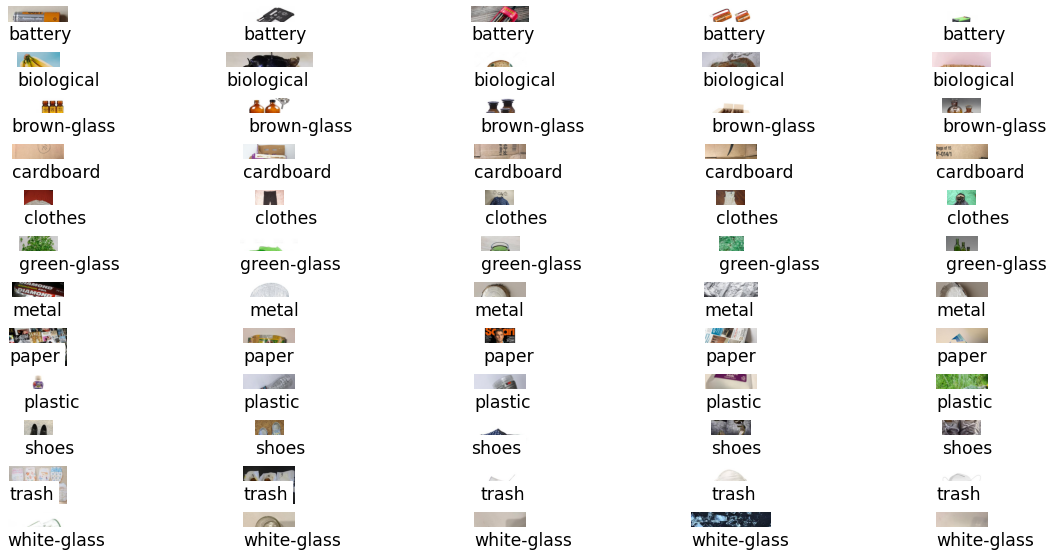

In [24]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [25]:
# Preparing labels for the models' config

label2id = {} # dic of format {"class_name": index}
id2label = {} # dic of format {index: "class_name"}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [32]:
# Init Feature Extractor, model, data loaders
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Downloading: 100%|██████████| 502/502 [00:00<00:00, 207kB/s]
Downloading: 100%|██████████| 346M/346M [00:13<00:00, 25.1MB/s] 
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probab

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])